In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder,StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.svm import SVC, LinearSVC
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import StackingClassifier, VotingClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score
from scipy import stats
import warnings
from itertools import combinations
import seaborn as sns
import math

In [ ]:
# from google.colab import files
# uploaded = files.upload()

Saving test.csv to test.csv
Saving train.csv to train.csv


In [ ]:
X = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
X.drop(['id'], axis=1, inplace=True)
test_id = test['id']
test.drop(['id'], axis=1, inplace=True)

In [ ]:
X.shape

(22792, 15)

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22792 entries, 0 to 22791
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   age                  22792 non-null  int64 
 1   Working Section      22792 non-null  object
 2   Financial Weight     22792 non-null  int64 
 3   education            22792 non-null  object
 4   education-num        22792 non-null  int64 
 5   Marriage Status      22792 non-null  object
 6   occupation           22792 non-null  object
 7   Relationship Status  22792 non-null  object
 8   Skin Color           22792 non-null  object
 9   Gender               22792 non-null  object
 10  Capital Gain         22792 non-null  int64 
 11  Capital Loss         22792 non-null  int64 
 12  hours-per-week       22792 non-null  int64 
 13  Country              22792 non-null  object
 14  Predictions          22792 non-null  object
dtypes: int64(6), object(9)
memory usage: 2.6+ MB


In [ ]:
X.describe().T

,count,mean,std,min,25%,50%,75%,max
age,22792.0,38.555414,13.619696,17.0,28.00,37.0,47.0,90.0
Financial Weight,22792.0,189858.356792,105932.263433,12285.0,117765.25,178605.5,237732.0,1484705.0
education-num,22792.0,10.076737,2.582573,1.0,9.00,10.0,12.0,16.0
Capital Gain,22792.0,1053.415716,7223.331352,0.0,0.00,0.0,0.0,99999.0
Capital Loss,22792.0,86.643603,402.098547,0.0,0.00,0.0,0.0,4356.0
hours-per-week,22792.0,40.441032,12.316680,1.0,40.00,40.0,45.0,99.0


In [ ]:
X.head()

,age,Working Section,Financial Weight,education,education-num,Marriage Status,occupation,Relationship Status,Skin Color,Gender,Capital Gain,Capital Loss,hours-per-week,Country,Predictions
0,48,Private,138970,Bachelors,13,Married Civilian,Exec-managerial,Husband,White,Male,0,0,45,United-States,Rich
1,21,State Govenment,96483,Some-college,10,No Marriage,Adm-clerical,Own-child,Asian-Pac-Islander,Female,0,0,12,United-States,Poor
2,49,Private,228583,HS-grad,9,Divorced,Other-service,Unmarried,White,Male,0,0,40,Columbia,Poor
3,40,Private,130760,Assoc-voc,11,Married Civilian,Exec-managerial,Husband,White,Male,0,0,50,United-States,Rich
4,55,Local Government,223716,Some-college,10,Divorced,Exec-managerial,Not-in-family,Amer-Indian-Eskimo,Female,0,0,40,United-States,Poor


Replacing '?' to nan values

In [ ]:
X = X.replace('?', np.nan)
test = test.replace('?', np.nan)

In [ ]:
print(X.isna().sum())
print(test.isna().sum())

age                       0
Working Section        1266
Financial Weight          0
education                 0
education-num             0
Marriage Status           0
occupation             1270
Relationship Status       0
Skin Color                0
Gender                    0
Capital Gain              0
Capital Loss              0
hours-per-week            0
Country                 413
Predictions               0
dtype: int64
age                      0
Working Section        570
Financial Weight         0
education                0
education-num            0
Marriage Status          0
occupation             573
Relationship Status      0
Skin Color               0
Gender                   0
Capital Gain             0
Capital Loss             0
hours-per-week           0
Country                170
dtype: int64


Checking unique categories for some Categorical Features.

In [ ]:
X['Working Section'].value_counts()

Private                 15895
Self Employed No Inc     1798
Local Government         1459
State Govenment           943
Self Employed + Inc       771
Police                    647
No Pay                      9
Never Worked                4
Name: Working Section, dtype: int64

In [ ]:
X['occupation'].value_counts()

Prof-specialty       2967
Craft-repair         2891
Exec-managerial      2799
Adm-clerical         2624
Sales                2607
Other-service        2272
Machine-op-inspct    1432
Transport-moving     1094
Handlers-cleaners     965
Farming-fishing       657
Tech-support          645
Protective-serv       456
Priv-house-serv       105
Armed-Forces            8
Name: occupation, dtype: int64

In [ ]:
X['Country'].value_counts()

United-States                 20382
Mexico                          465
Philippines                     134
Germany                          92
Puerto-Rico                      88
Canada                           85
El-Salvador                      81
Cuba                             73
India                            66
Jamaica                          59
England                          59
Dominican-Republic               57
Vietnam                          51
China                            50
Columbia                         49
Poland                           48
Guatemala                        48
South                            48
Italy                            46
Japan                            42
Taiwan                           39
Iran                             30
Haiti                            29
Portugal                         29
Greece                           23
Peru                             21
Nicaragua                        20
France                      

As the category United States dominate the 'Country' feature , we categorized all other countries to 'other'.

In [ ]:
X['Country'] = ['United-States' if x == 'United-States' else 'other' for x in X['Country']]
test['Country'] = ['United-States' if x == 'United-States' else 'other' for x in test['Country']]
X['Predictions'] = [1 if x == 'Rich' else 0 for x in X['Predictions']]

Exploratory Data Analysis.

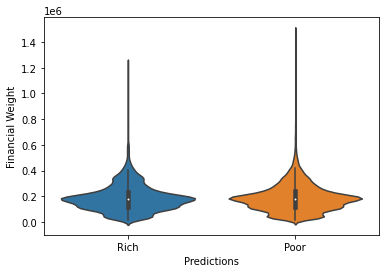

In [ ]:
sns.violinplot(y=X["Financial Weight"], x=X["Predictions"])

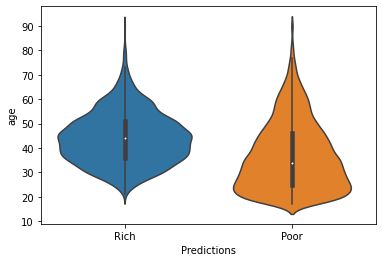

In [ ]:
sns.violinplot(y=X["age"], x=X["Predictions"])


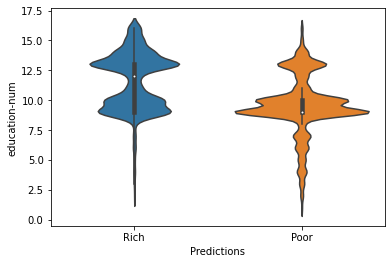

In [ ]:
sns.violinplot(y=X["education-num"], x=X["Predictions"])


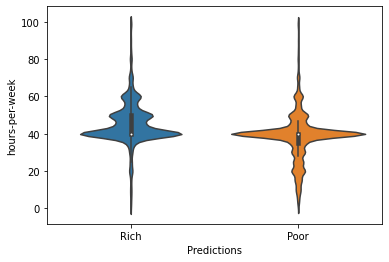

In [ ]:
sns.violinplot(y=X["hours-per-week"], x=X["Predictions"])


Checking for Outliers

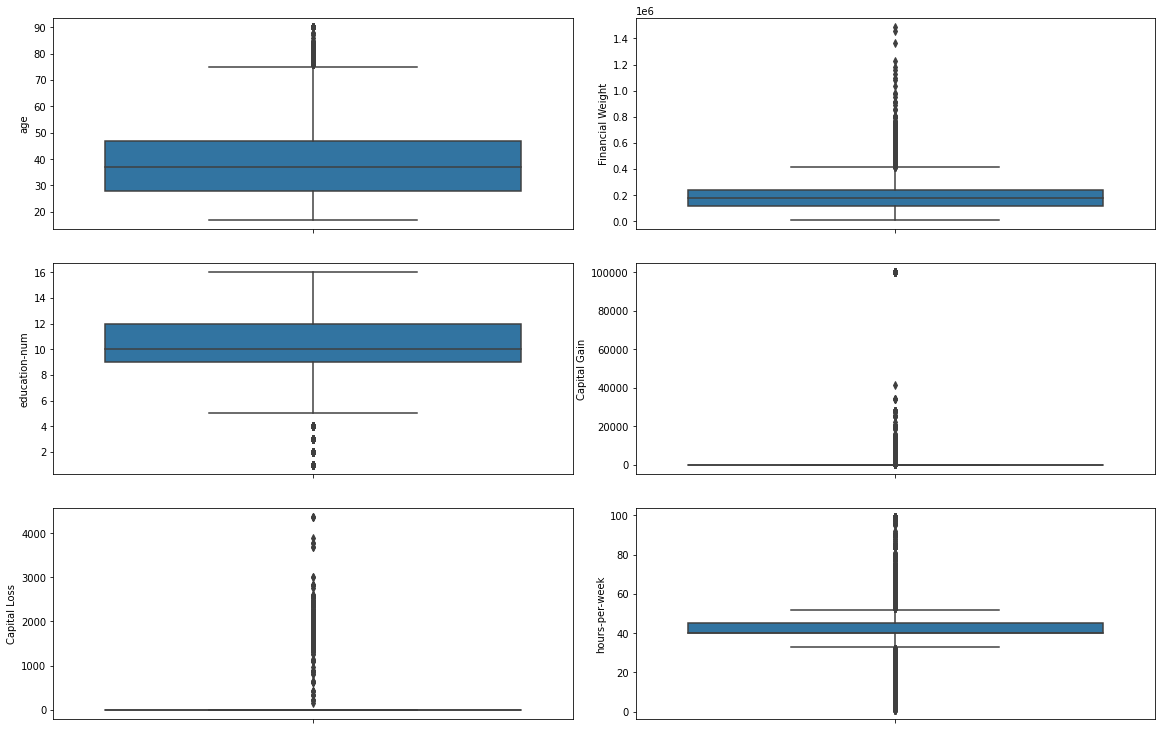

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(16,10))
index = 0
ax = ax.flatten()

for x in X.columns:
    if X[x].dtype == object:
      continue
    sns.boxplot(y=x, data=X, ax=ax[index])
    index += 1
plt.tight_layout(pad=0.2, w_pad=0.4, h_pad=3.0)

In [ ]:
def remove_outlier(df):
    
    df1 = df.copy()
    df = df._get_numeric_data()
    q1 = df.quantile(0.25)
    q3 = df.quantile(0.75)

    iqr = q3 - q1

    lb = q1 - (1.5 * iqr)
    ub = q3 + (1.5 * iqr)
    # print(df.columns)
    indexes = []
    for col in df.columns:
        if df[col].dtype == object:
          print(col)
          continue
        for i in range(df.shape[0]):
            if df[col][i] < lb[col]:            
                df[col][i] = lb[col]
                # indexes.append(i)

            if df[col][i] > ub[col]:            
                df[col][i] = ub[col]
                # indexes.append(i)       
    # df1 = df1.drop(indexes, axis=0)
    for col in df.columns:
        df1[col] = df[col]
    print(df1.columns)
    return df1

The number of outliers were not decisive.
Removing outliers was not feasible.

In [ ]:
# X.columns
# X = remove_outlier(X)

Checking for correlated features.

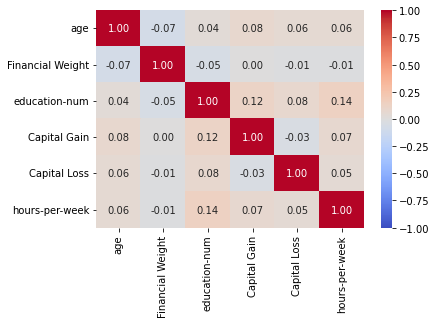

In [ ]:
sns.heatmap(X.corr(), vmin=-1, vmax=1, cmap="coolwarm", annot=True, fmt='.2f')

Plotting Distribution graphs.

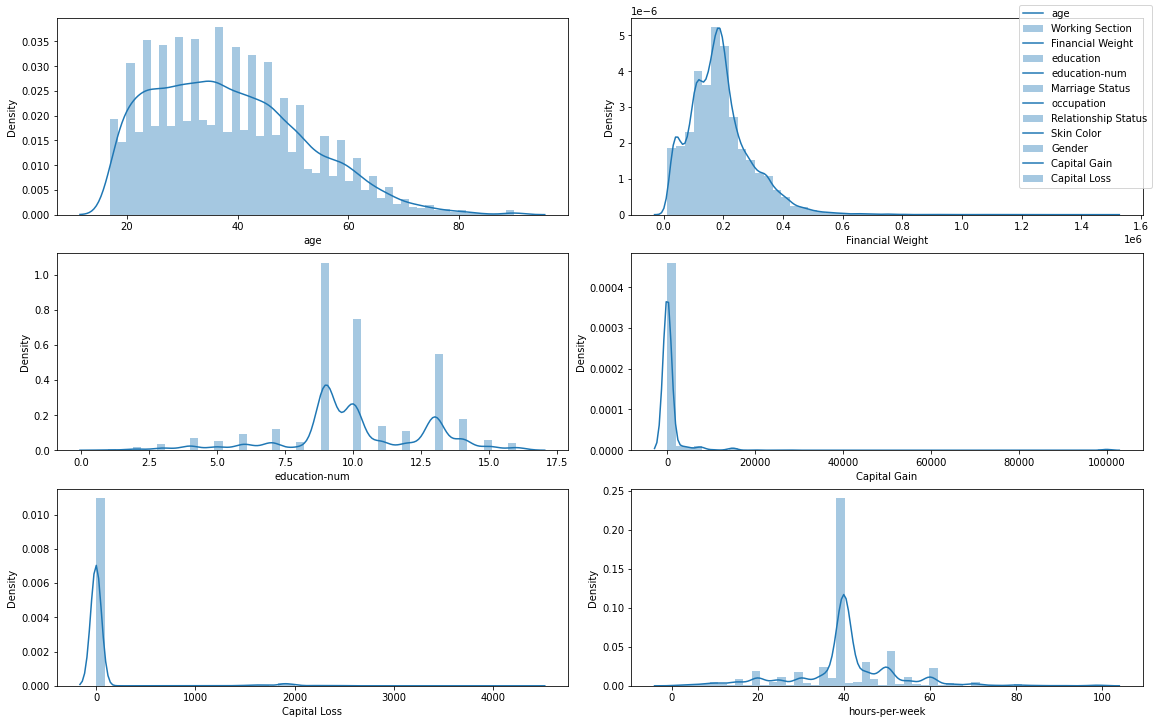

In [ ]:
warnings.filterwarnings("ignore")
fig,ax = plt.subplots(nrows=3, ncols=2, figsize=(16,10))
index = 0
ax = ax.flatten()

for x in X.columns:
    if X[x].dtype == object:
      continue
    sns.distplot(X[x], ax=ax[index])
    index += 1
fig.legend(labels=X.columns)
plt.tight_layout(pad=0.5, h_pad=0.5, w_pad=0.5)

In [ ]:
y = X['Predictions']
X.drop(['Predictions'], axis=1, inplace=True)

Separating Categorical and numerical features

In [ ]:
num_features = []
char_features = []
for x in X.columns:
    if(X[x].dtypes == object):
        char_features.append(x)
    else:
        num_features.append(x)

print(num_features)
print(char_features)

['age', 'Financial Weight', 'education-num', 'Capital Gain', 'Capital Loss', 'hours-per-week']
['Working Section', 'education', 'Marriage Status', 'occupation', 'Relationship Status', 'Skin Color', 'Gender', 'Country']


Creating a Pipeline for executing preprocessing tasks together
##### This makes our task easier for both training and testing data.

In [ ]:
object_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehotencoder', OneHotEncoder())
])
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('minmaxscaler', StandardScaler()),
])
full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_features),
    ('char', object_pipeline, char_features),

])

X_encoded = full_pipeline.fit_transform(X)
test_encoded = full_pipeline.transform(test)

In [ ]:
print(X_encoded.shape)
print(test_encoded.shape)

(22792, 66)
(9769, 66)


Adding interaction among the features in the data.(Increasing Dimensionality).

In [ ]:
def add_interactions_train(df):

  poly = PolynomialFeatures(interaction_only=True, include_bias=False)
  df = poly.fit_transform(df)

  return df



In [ ]:
X_encoded = add_interactions_train(X_encoded.toarray())
test_encoded = add_interactions_train(test_encoded.toarray())

In [ ]:
print(X_encoded.shape , test_encoded.shape)

Reducing Dimensionality by using PCA

In [ ]:
pca = PCA(n_components=100)
X_encoded = pca.fit_transform(X_encoded)
test_encoded= pca.transform(test_encoded)

In [ ]:
X_encoded.shape

(22792, 100)

Evaluating model using Stratified K Fold Cross validation.

In [ ]:
def evaluate_model(X, y, model):
	
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

	scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
	return scores

In [ ]:
X_train,X_valid,y_train,y_valid = train_test_split(X_encoded,y, random_state=0, shuffle=True, train_size=0.8)

Stacking classifiers

In [ ]:
gb = GaussianNB()
lr = LogisticRegression(random_state=0)
bb = BernoulliNB()
ls = SVC(C=100, probability=True)
model = StackingClassifier( estimators=[
    ('gb',gb),
    ('lr',lr),
    ('bb',bb),
    ('ls',ls)],
    n_jobs=-1,
)

In [ ]:
model.fit(X_train,y_train)
roc_auc_score(y_valid,model.predict_proba(X_valid)[:,1])
# print(evaluate_model(X_encoded,y,model))

0.9053376372597053

In [ ]:
roc_auc_score(y_train,model.predict_proba(X_train)[:,1])


0.9350202595723531

In [ ]:
test_pred = model.predict_proba(test_encoded)[:,1]
outcome = pd.DataFrame(test_pred)
result = pd.concat([test_id,outcome], axis=1)
result.columns = ['id','Predictions']
result.to_csv('result.csv',encoding='utf-8', columns=['id','Predictions'], index=False)
result

,id,Predictions
0,13102,0.064727
1,19586,0.040034
2,29215,0.059181
3,23331,0.241688
4,31935,0.036959
...,...,...
9764,4937,0.040181
9765,9710,0.061279
9766,8835,0.046572
9767,31470,0.040530
